In [1]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not on google colab")

not on google colab


In [46]:
# Dataset
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = '../VISCHEMA_PLUS/', label_dir = '../VISCHEMA_PLUS/vms/', transform = None):
        
        all_images = pd.read_csv(f"{dataset_dir}viscplus_val.csv", header=None)
        
        self.transform = transform
        self.label_dir = label_dir
        self.all_images = natsorted(all_images[0])
        self.dataset_dir = dataset_dir
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        with open("file_to_category.pkl", "rb") as file:
            file_to_cat = pickle.load(file)

        image_category = file_to_cat[self.all_images[idx]]

        image = Image.open(f"{self.dataset_dir}images/{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}vms/{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label, image_category

In [3]:
# UNET
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

In [47]:
# Set up our training environment

# Dataloaders
image_transforms = transforms.Compose([
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])

val_dataset   = VISCHEMA_PLUS(transform = image_transforms)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = 1, shuffle=True)
print(f'{len(val_dataset)}  Items in val dataset')

# Network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
model.load_state_dict(torch.load("checkpoints/run2/best_weights.pkl"))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet')

320  Items in val dataset
31031875 Parameters in UNet


In [53]:
# Validation Loop
from tqdm import tqdm
print('Starting Validation')

category_losses = {} # Logging
total_loss = 0
loss_func = torch.nn.L1Loss()

def blackout_tensor(image):

    output = torch.clone(image)
    output[:,1] *= 0
    output[:,1] -= 1
    output[:,2] *= 0
    output[:,2] -= 1  

    return output

model.eval()
with torch.no_grad():
    for image, label, cat in tqdm(val_loader):

        # Move images to device and create prediction
        image, label = image.to(device), label.to(device)
        output = model(image)

        #Evaluate the loss
        loss = loss_func(blackout_tensor(output),blackout_tensor(label))
        
        total_loss += loss.item()

        if cat[0] in category_losses:
            category_losses[cat[0]] += [loss.item()]
        else:
            category_losses[cat[0]] = [loss.item()]
        
        del image, label, output, cat
        torch.cuda.empty_cache()


Starting Validation


100%|██████████| 320/320 [00:09<00:00, 32.77it/s]


In [54]:
for key in category_losses.keys():
    category_losses[key] = np.mean(category_losses[key])
    print(key, category_losses[key])

print(f"Average loss: {total_loss/len(val_loader)}")

big 0.02661177253771928
conference_room 0.08101891614274964
isolated 0.04759527736014741
populated 0.012266142385717677
playground 0.059464691689104905
kitchen 0.044463653315324335
small 0.02879853359742188
airport_terminal 0.07187960795617025
golf_course 0.055669605696144014
mountain 0.07916211329367277
public-entertainment 0.030252949539793746
work-home 0.03769531178598603
living room 0.013748132804175838
living_room 0.04000693766283803
skyscraper 0.12765768594108523
badlands 0.09822849246362846
house 0.037173117091879246
amusement_park 0.05981842910599274
pasture 0.04287697393738199
Average loss: 0.047803090693923876


In [52]:
print(f"Mean loss: {np.mean(list(category_losses.values()))}")
print(f"STD of losses: {np.std(list(category_losses.values()))}")

Mean loss: 0.13992937144671244
STD of losses: 0.051684013454625026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


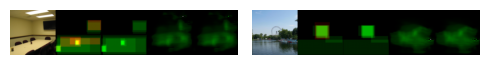

In [33]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 2, 2

for i in range(rows):

    images, labels, _ = next(iter(val_loader))
    images= images.to(device)
    output = model(images)

    label_green = torch.clone(labels)
    label_green[:,0] *= 0
    label_green[:,0] -= 1
    label_green[:,2] *= 0
    label_green[:,2] -= 1

    output_green = torch.clone(output)
    output_green[:,0] *= 0
    output_green[:,0] -= 1
    output_green[:,2] *= 0
    output_green[:,2] -= 1  

    print(images.size())
    print(labels.size())
    print(output.size())
    print(label_green.size())
    print(output_green.size())

    display = torch.cat([images.to("cpu"), labels, label_green, output.to("cpu").detach(), output_green.to("cpu").detach()], dim=3)

    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow((display[0].squeeze().permute(1, 2, 0) +1 )/2 )

    
plt.tight_layout()
plt.show()